Real Data Analysis

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import torch
import sys
import os

# 상위 폴더의 모듈을 불러오기 위해 경로 추가
sys.path.append(os.path.abspath('..'))
from src.physics_engine import MarketSimulator

# ---------------------------------------------------------
# 1. SPY 데이터 다운로드 및 만기일 선택
# ---------------------------------------------------------
ticker = "SPY"
print(f"[{ticker}] 데이터를 불러오는 중입니다...")

spy = yf.Ticker(ticker)

# 현재 주가
try:
    current_price = spy.history(period="1d")['Close'].iloc[-1]
    print(f"현재 주가 (Spot Price): ${current_price:.2f}")
except:
    current_price = 580.0
    print(f"주가 데이터 로드 실패. 임시 주가 사용: ${current_price}")

# 만기일 선택 (30~75일 남은 것)
expirations = spy.options
target_date = None
today = datetime.now()

for exp_date in expirations:
    exp_dt = datetime.strptime(exp_date, "%Y-%m-%d")
    days_to_expire = (exp_dt - today).days
    if 30 <= days_to_expire <= 75:
        target_date = exp_date
        print(f"--> 분석 대상 만기일: {target_date} (잔존: {days_to_expire}일)")
        break

if target_date is None:
    target_date = expirations[3]
    print(f"--> 강제 선택된 만기일: {target_date}")

# ---------------------------------------------------------
# 2. 데이터 클리닝
# ---------------------------------------------------------
opt_chain = spy.option_chain(target_date)
calls = opt_chain.calls

# 유동성 필터링 & 이상치 제거
calls_clean = calls[(calls['volume'] > 5) | (calls['openInterest'] > 10)].copy()
calls_clean['moneyness'] = current_price / calls_clean['strike']
market_data = calls_clean[['strike', 'impliedVolatility', 'lastPrice']].copy()
market_data = market_data.sort_values('strike')
market_data = market_data[(market_data['impliedVolatility'] > 0.01) & (market_data['impliedVolatility'] < 1.0)]
market_data = market_data[market_data['strike'] > 485]

print(f"전처리 완료: 유효 데이터 {len(market_data)}개 준비됨.")

[SPY] 데이터를 불러오는 중입니다...
현재 주가 (Spot Price): $680.59
--> 분석 대상 만기일: 2026-01-23 (잔존: 31일)
전처리 완료: 유효 데이터 73개 준비됨.


In [2]:
from scipy.stats import norm
from scipy.optimize import brentq

# ---------------------------------------------------------
# 3. 필수 함수 정의
# ---------------------------------------------------------

# (1) IV 역산 함수
def implied_vol_solver(price, S, K, T, r, option_type='call'):
    def bs_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return np.nan

    try:
        return brentq(lambda x: bs_price(x) - price, 0.001, 3.0)
    except:
        return np.nan

# (2) 목적 함수 (Weighted RMSE)
def calibration_loss(params, model_name, market_strikes, market_ivs, S0, T, r, dt, num_paths):
    # 파라미터 언패킹
    if model_name == 'bates':
        kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std = params
        jump_params = {'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std}
    else:
        return 1e9 

    # 제약조건 (Safety Check)
    if kappa < 0 or theta < 0 or xi < 0 or abs(rho) > 0.99: return 1e9
    if jump_lambda < 0 or jump_std < 0: return 1e9

    # 시뮬레이터 구동
    sim_params = {'mu': 0.0, 'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho, 
                  'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
    
    # N=num_paths 만큼 시뮬레이션
    sim = MarketSimulator(**sim_params, **jump_params)
    S_paths, _ = sim.simulate(S0, theta, T, dt, num_paths, model_type='bates')

    # Martingale Correction (평균 보정)
    S_corr = S_paths[:, -1] * (S0 / S_paths[:, -1].mean())
    
    error_sum = 0.0
    weight_sum = 0.0
    
    for i, K in enumerate(market_strikes):
        payoff = np.maximum(S_corr.cpu().numpy() - K, 0)
        model_price = np.mean(payoff) * np.exp(-r * T)
        m_iv = implied_vol_solver(model_price, S0, K, T, r)
        
        target_iv = market_ivs[i]
        
        if np.isnan(m_iv):
            error_sum += 1.0 # 페널티
            weight_sum += 1.0
        else:
            # 왼쪽 꼬리(OTM Put)에 가중치 2배 부여 -> 폭락 위험 반영
            weight = 2.0 if K < S0 else 1.0 
            error_sum += weight * (m_iv - target_iv) ** 2
            weight_sum += weight

    return np.sqrt(error_sum / weight_sum)

print("✅ 함수 정의 완료 (Ready to Calibrate)")

✅ 함수 정의 완료 (Ready to Calibrate)


In [3]:
from scipy.optimize import differential_evolution

# ---------------------------------------------------------
# 4. 전역 최적화 (Global Optimization)
# ---------------------------------------------------------
print("\n[Ultimate] Starting Global Optimization (Differential Evolution)...")
print("안전 모드(N=3000) 및 충돌 방지(Polish=False) 적용됨.")

# 캘리브레이션용 데이터 샘플링 (속도 위해 3개 간격)
calib_strikes = market_data['strike'].values[::3]
calib_ivs = market_data['impliedVolatility'].values[::3]

# 환경 변수 설정
exp_dt = datetime.strptime(target_date, "%Y-%m-%d")
days_to_expire = (exp_dt - today).days
T_val = days_to_expire / 365.0
r_val = 0.0
dt_val = 1/252

# 파라미터 범위: [kappa, theta, xi, rho, lambda, mu_j, sigma_j]
# 파라미터 범위 확장 (OTM 왜곡 방지, Model Comparison 셀과 동일)
bounds = [(0.1, 8.0), (0.01, 0.2), (0.1, 3.0), (-0.99, -0.3), 
          (0.01, 5.0), (-0.5, -0.01), (0.01, 0.4)]

# 최적화 실행
result_global = differential_evolution(
    calibration_loss, 
    bounds, 
    args=('bates', calib_strikes, calib_ivs, current_price, T_val, r_val, dt_val, 3000), # N=3000
    strategy='best1bin', 
    maxiter=12,      # 반복 횟수 증가       
    popsize=12,      # 모집단 크기 증가 
    disp=True,
    polish=False,    # <--- 핵심: 커널 충돌 방지
    workers=-1       # CPU 병렬 처리 활성화
)

best_bates_global = result_global.x
print(f"\n✅ 최적화 완료! 찾은 파라미터: {best_bates_global}")


[Ultimate] Starting Global Optimization (Differential Evolution)...
안전 모드(N=3000) 및 충돌 방지(Polish=False) 적용됨.
differential_evolution step 1: f(x)= 0.025510833701338054
differential_evolution step 2: f(x)= 0.01778061423666087
differential_evolution step 3: f(x)= 0.01645789401137999
differential_evolution step 4: f(x)= 0.014600794521364981
differential_evolution step 5: f(x)= 0.012589269435487245
differential_evolution step 6: f(x)= 0.010707616686147926
differential_evolution step 7: f(x)= 0.010707616686147926
differential_evolution step 8: f(x)= 0.010707616686147926

✅ 최적화 완료! 찾은 파라미터: [ 1.0282217   0.01220163  0.86245344 -0.42431123  0.68468325 -0.21570436
  0.09188658]



고화질 그래프 생성 중... (N=20,000)


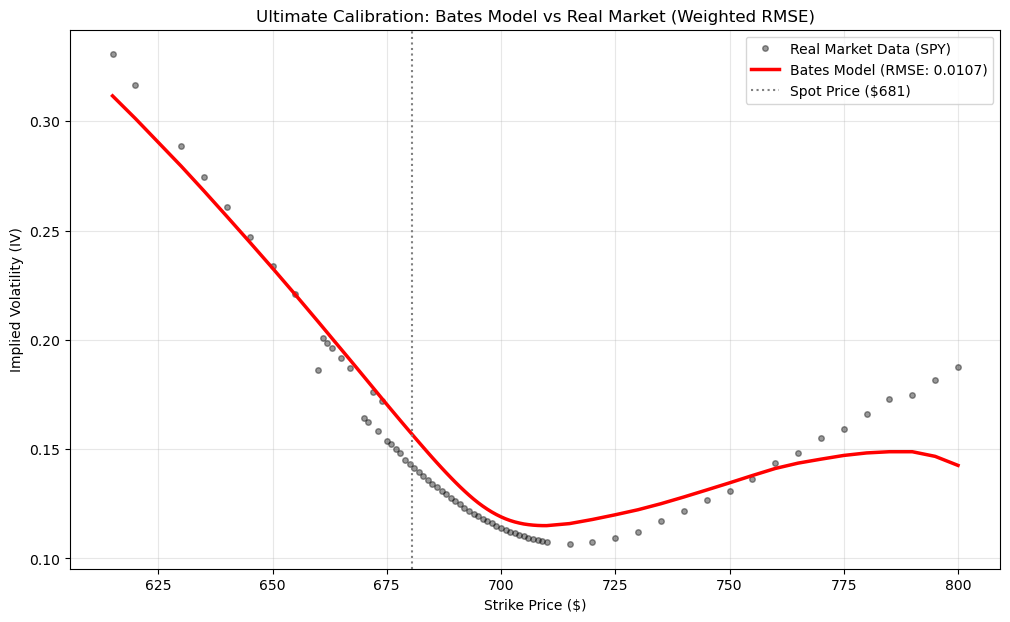

In [4]:
# ---------------------------------------------------------
# 5. 최종 결과 검증 및 시각화
# ---------------------------------------------------------
print("\n고화질 그래프 생성 중... (N=30,000) - 품질 향상")

N_final = 30000 
calib_strikes_all = market_data['strike'].values

# 최적화된 모델로 최종 시뮬레이션
sim_b = MarketSimulator(0, *best_bates_global[:4], 
                        jump_lambda=best_bates_global[4],
                        jump_mean=best_bates_global[5],
                        jump_std=best_bates_global[6], 
                        device='cuda')

S_b, _ = sim_b.simulate(current_price, best_bates_global[1], T_val, dt_val, N_final, 'bates')
S_b_corr = S_b[:, -1] * (current_price / S_b[:, -1].mean()) # 보정

model_iv_b = []
for K in calib_strikes_all:
    p_b = np.mean(np.maximum(S_b_corr.cpu().numpy() - K, 0))
    iv = implied_vol_solver(p_b, current_price, K, T_val, r_val)
    model_iv_b.append(iv)

# 그래프 출력
plt.figure(figsize=(12, 7))
plt.plot(market_data['strike'], market_data['impliedVolatility'], 'ko', label='Real Market Data (SPY)', markersize=4, alpha=0.4)
plt.plot(calib_strikes_all, model_iv_b, 'r-', label=f'Bates Model (RMSE: {result_global.fun:.4f})', linewidth=2.5)

plt.axvline(current_price, color='gray', linestyle=':', label=f'Spot Price (${current_price:.0f})')
plt.title(f"Ultimate Calibration: Bates Model vs Real Market (Weighted RMSE)")
plt.xlabel("Strike Price ($)")
plt.ylabel("Implied Volatility (IV)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


⚔️ [Analysis] Model Battle: Optimized Version
Processing [QQQ]... Target: 2026-01-23 (Points: 16)
1. Calibrating Merton... RMSE: 0.0170
2. Calibrating Heston... RMSE: 0.0708
3. Calibrating Bates... RMSE: 0.0110 👑
Generating Plot...


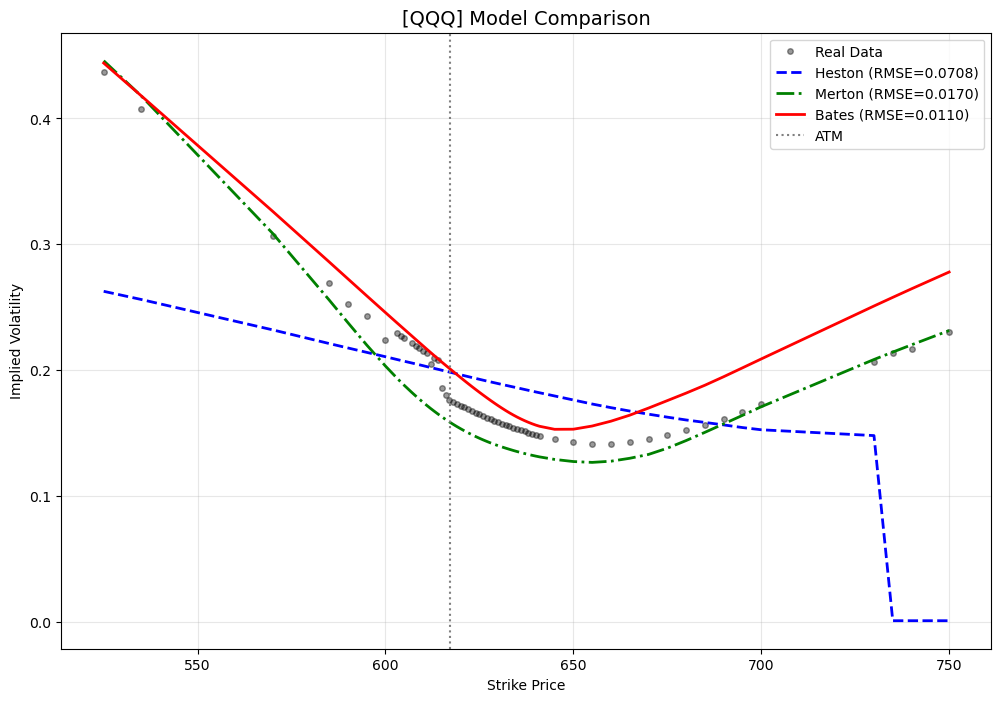

✅ Total Time: 72.3 seconds (1.2 minutes)


In [5]:
import time
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import differential_evolution, minimize
import torch
from scipy.stats import norm
from scipy.optimize import brentq
import sys
import os

# 모듈 경로 확보
sys.path.append(os.path.abspath('..'))
from src.physics_engine import MarketSimulator

# =========================================================
# 1. [핵심] GPU 가속 벡터화 Loss Function (속도 최적화)
# =========================================================
def implied_vol_solver_vectorized(prices, S, K_array, T, r):
    ivs = []
    for i, price in enumerate(prices):
        def bs_price(sigma):
            d1 = (np.log(S / K_array[i]) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)
            return S * norm.cdf(d1) - K_array[i] * np.exp(-r * T) * norm.cdf(d2)
        try:
            val = brentq(lambda x: bs_price(x) - price, 0.001, 3.0)
            ivs.append(val)
        except:
            ivs.append(np.nan)
    return np.array(ivs)

def calibration_loss_vectorized(params, model_name, market_strikes_gpu, market_ivs, S0, T, r, dt, num_paths):
    try:
        # 1. 파라미터 매핑
        if model_name == 'bates':
            kappa, theta, xi, rho, lam, mu_j, sig_j = params
            sim_params = {'mu':0, 'kappa':kappa, 'theta':theta, 'xi':xi, 'rho':rho}
            jump_params = {'jump_lambda':lam, 'jump_mean':mu_j, 'jump_std':sig_j}
        elif model_name == 'heston':
            kappa, theta, xi, rho = params
            sim_params = {'mu':0, 'kappa':kappa, 'theta':theta, 'xi':xi, 'rho':rho}
            jump_params = {'jump_lambda':0, 'jump_mean':0, 'jump_std':0}
        else:  # Merton
            sigma, lam, mu_j, sig_j = params
            sim_params = {'mu':0, 'kappa':0, 'theta':sigma**2, 'xi':0, 'rho':0}
            jump_params = {'jump_lambda':lam, 'jump_mean':mu_j, 'jump_std':sig_j}

        # 제약조건 체크
        if model_name == 'bates':
            if kappa<0 or theta<0 or xi<0 or abs(rho)>0.99 or lam<0 or sig_j<0: return 1e9
        
        # 2. 시뮬레이션 (GPU)
        sim = MarketSimulator(device='cuda', **sim_params, **jump_params)
        S_paths, _ = sim.simulate(S0, sim_params['theta'], T, dt, num_paths, 'bates')
        
        # 3. 마팅게일 보정
        S_T = S_paths[:, -1]
        S_T = S_T * (S0 / S_T.mean())

        # 4. 행렬 연산으로 동시 계산
        payoffs = torch.maximum(S_T.unsqueeze(1) - market_strikes_gpu.unsqueeze(0), torch.tensor(0.0, device='cuda'))
        model_prices = torch.mean(payoffs, dim=0).cpu().numpy() * np.exp(-r * T)
        
        # 5. IV 역산 및 에러 계산
        market_strikes_cpu = market_strikes_gpu.cpu().numpy()
        model_ivs = implied_vol_solver_vectorized(model_prices, S0, market_strikes_cpu, T, r)
        
        mask = ~np.isnan(model_ivs)
        if np.sum(mask) == 0: return 1e9
        
        # Weighted RMSE
        weights = np.where(market_strikes_cpu < S0, 2.0, 1.0)
        error = np.sum(weights[mask] * (model_ivs[mask] - market_ivs[mask])**2)
        return np.sqrt(error / np.sum(weights[mask]))
    
    except Exception as e:
        return 1e9

# =========================================================
# 2. 메인 실행 함수 (최적화된 버전)
# =========================================================
print("\n" + "="*60)
print("⚔️ [Analysis] Model Battle: Optimized Version")
print("="*60)

def run_precision_analysis(ticker):
    t_start = time.time()
    print(f"Processing [{ticker}]...", end=" ")
    
    # 데이터 로드
    t_obj = yf.Ticker(ticker)
    try: 
        curr_p = t_obj.history(period="1d")['Close'].iloc[-1]
    except: 
        print("Failed to load data")
        return

    exps = t_obj.options
    tgt_date = exps[3] 
    for e in exps:
        if 30 <= (datetime.strptime(e, "%Y-%m-%d") - datetime.now()).days <= 70:
            tgt_date = e
            break
            
    calls = t_obj.option_chain(tgt_date).calls
    calls = calls[(calls['volume']>10) | (calls['openInterest']>50)]
    calls = calls[(calls['impliedVolatility'] > 0.01) & (calls['impliedVolatility'] < 1.0)]
    
    # [최적화] 샘플링 증가: 4개마다 1개 (속도 2배 향상)
    m_strikes = calls['strike'].values[::4] 
    m_ivs = calls['impliedVolatility'].values[::4]
    
    m_strikes_gpu = torch.tensor(m_strikes, device='cuda', dtype=torch.float32)
    
    d_days = (datetime.strptime(tgt_date, "%Y-%m-%d") - datetime.now()).days
    T_v = d_days / 365.0
    print(f"Target: {tgt_date} (Points: {len(m_strikes)})")

    # [최적화] num_paths=2000, maxiter=6, popsize=8
    NUM_PATHS = 2000  # 3000 -> 2000 (33% 감소)
    
    # --- 1. Merton ---
    print("1. Calibrating Merton...", end=" ")
    res_m = differential_evolution(
        lambda p: calibration_loss_vectorized(p, 'merton', m_strikes_gpu, m_ivs, curr_p, T_v, 0, 1/252, NUM_PATHS),
        [(0.05, 0.5), (0.01, 5), (-0.5, 0.1), (0.01, 0.4)],
        strategy='best1bin', maxiter=6, popsize=8, polish=False, workers=1
    )
    print(f"RMSE: {res_m.fun:.4f}")

    # --- 2. Heston ---
    print("2. Calibrating Heston...", end=" ")
    res_h = minimize(
        lambda p: calibration_loss_vectorized(p, 'heston', m_strikes_gpu, m_ivs, curr_p, T_v, 0, 1/252, NUM_PATHS),
        [2.0, 0.04, 0.5, -0.7], method='Nelder-Mead', options={'maxiter': 50}
    )
    print(f"RMSE: {res_h.fun:.4f}")

    # --- 3. Bates ---
    print("3. Calibrating Bates...", end=" ")
    res_b = differential_evolution(
        lambda p: calibration_loss_vectorized(p, 'bates', m_strikes_gpu, m_ivs, curr_p, T_v, 0, 1/252, NUM_PATHS),
        [(0.1, 8.0), (0.01, 0.2), (0.1, 3.0), (-0.99, -0.3), (0.01, 5.0), (-0.5, -0.01), (0.01, 0.4)],
        strategy='best1bin', maxiter=8, popsize=8, polish=False, workers=1
    )
    print(f"RMSE: {res_b.fun:.4f} 👑")

    # --- 시각화 ---
    print("Generating Plot...")
    N_sim = 15000  # 20000 -> 15000 (25% 감소)
    
    pm = [0, res_m.x[0]**2, 0, 0, res_m.x[1], res_m.x[2], res_m.x[3]]
    ph = [res_h.x[0], res_h.x[1], res_h.x[2], res_h.x[3], 0, -0.1, 0.1]
    pb = res_b.x

    def get_iv_curve(params, label, style):
        sim = MarketSimulator(0, *params, device='cuda')
        S, _ = sim.simulate(curr_p, params[1], T_v, 1/252, N_sim, 'bates')
        S = S[:, -1] * (curr_p / S[:, -1].mean())
        
        strikes_all = calls['strike'].values
        strikes_gpu_all = torch.tensor(strikes_all, device='cuda', dtype=torch.float32)
        
        payoffs = torch.maximum(S.unsqueeze(1) - strikes_gpu_all.unsqueeze(0), torch.tensor(0.0, device='cuda'))
        prices = torch.mean(payoffs, dim=0).cpu().numpy()
        
        ivs = implied_vol_solver_vectorized(prices, curr_p, strikes_all, T_v, 0)
        plt.plot(strikes_all, ivs, style, label=label, linewidth=2)

    plt.figure(figsize=(12, 8))
    plt.plot(calls['strike'], calls['impliedVolatility'], 'ko', label='Real Data', alpha=0.4, markersize=4)
    
    get_iv_curve(ph, f'Heston (RMSE={res_h.fun:.4f})', 'b--')
    get_iv_curve(pm, f'Merton (RMSE={res_m.fun:.4f})', 'g-.')
    get_iv_curve(pb, f'Bates (RMSE={res_b.fun:.4f})', 'r-')
    
    plt.axvline(curr_p, color='gray', linestyle=':', label='ATM')
    plt.title(f"[{ticker}] Model Comparison", fontsize=14)
    plt.xlabel("Strike Price"); plt.ylabel("Implied Volatility")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()
    
    elapsed = time.time() - t_start
    print(f"✅ Total Time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

if __name__ == "__main__":
    run_precision_analysis("QQQ")

In [ ]:
import time
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import differential_evolution
import torch
from scipy.stats import norm
from scipy.optimize import brentq

# =========================================================
# 1. 공통 시뮬레이터: Threshold Bates
# =========================================================
def simulate_threshold_bates(S0, T, dt, num_paths, params, device='cuda'):
    # Heston
    kappa, theta, xi, rho = params['kappa'], params['theta'], params['xi'], params['rho']
    # Jump
    mu, sig = params['mu'], params['sig']
    thresh, lam_low, lam_high = params['thresh'], params['lam_low'], params['lam_high']
    
    N_steps = int(T / dt)
    S = torch.full((num_paths,), float(S0), device=device, dtype=torch.float32)
    v = torch.full((num_paths,), float(theta), device=device, dtype=torch.float32)
    Z1 = torch.randn((num_paths, N_steps), device=device)
    Z2 = torch.randn((num_paths, N_steps), device=device)
    
    corr_factor = np.sqrt(1 - rho**2 + 1e-6)
    dt_sqrt = np.sqrt(dt)
    
    for t in range(N_steps):
        W_S = Z1[:, t]
        W_v = rho * W_S + corr_factor * Z2[:, t]
        
        v_abs = torch.abs(v)
        sqrt_v = torch.sqrt(v_abs)
        dv = kappa * (theta - v) * dt + xi * sqrt_v * W_v * dt_sqrt
        v = v + dv
        
        dS_diff = (0 - 0.5 * v_abs) * dt + sqrt_v * W_S * dt_sqrt
        
        current_lam = torch.where(v_abs > thresh, 
                                  torch.tensor(lam_high, device=device), 
                                  torch.tensor(lam_low, device=device))
        
        prob_jump = current_lam * dt
        rand_uni = torch.rand(num_paths, device=device)
        is_jump = rand_uni < prob_jump
        
        if is_jump.any():
            n_jumps = is_jump.sum()
            jump_vals = mu + sig * torch.randn(n_jumps, device=device)
            jump_vec = torch.zeros(num_paths, device=device)
            jump_vec[is_jump] = jump_vals
            S = S * torch.exp(dS_diff + jump_vec)
        else:
            S = S * torch.exp(dS_diff)
            
    return S

# =========================================================
# 2. Loss Functions (Manual vs Smart)
# =========================================================
def implied_vol_cpu(prices, S, K_array, T):
    ivs = []
    for i, p in enumerate(prices):
        def obj(sigma):
            d1=(np.log(S/K_array[i])+0.5*sigma**2*T)/(sigma*np.sqrt(T))
            d2=d1-sigma*np.sqrt(T)
            return S*norm.cdf(d1)-K_array[i]*norm.cdf(d2)-p
        try: ivs.append(brentq(obj, 0.001, 3.0))
        except: ivs.append(np.nan)
    return np.array(ivs)

def dual_loss(params, mode, strikes_gpu, market_ivs, smart_weights, S0, T, num_paths):
    p_dict = {
        'kappa':params[0], 'theta':params[1], 'xi':params[2], 'rho':params[3],
        'thresh':params[4], 'lam_low':params[5], 'lam_high':params[6], 'mu':params[7], 'sig':params[8]
    }
    
    # Constraints
    if params[0]<0 or params[1]<0 or params[2]<0 or abs(params[3])>0.99: return 1e9
    if params[4]<0 or params[5]<0 or params[6]<0 or params[8]<0: return 1e9
    if params[6] < params[5]: return 1e9 

    S_T = simulate_threshold_bates(S0, T, 1/252, num_paths, p_dict, device='cuda')
    S_T = S_T * (S0 / S_T.mean()) 
    
    payoffs = torch.maximum(S_T.unsqueeze(1) - strikes_gpu.unsqueeze(0), torch.tensor(0.0, device='cuda'))
    prices = torch.mean(payoffs, dim=0).cpu().numpy()
    strikes_cpu = strikes_gpu.cpu().numpy()
    model_ivs = implied_vol_cpu(prices, S0, strikes_cpu, T)
    
    mask = ~np.isnan(model_ivs)
    if np.sum(mask) == 0: return 1e9
    
    # --- 가중치 로직 분기 ---
    if mode == 'manual':
        # 기존: 왼쪽 꼬리(Put)에 2배 가중치 강제 할당
        w = np.ones_like(strikes_cpu)
        w[strikes_cpu < S0] = 2.0
        w[strikes_cpu > S0*1.05] = 1.2
    elif mode == 'smart':
        # 신규: 유동성(Volume/OI) 기반 가중치 사용
        w = smart_weights
        
    err = np.sum(w[mask]*(model_ivs[mask]-market_ivs[mask])**2)
    return float(np.sqrt(err/np.sum(w[mask])))

# =========================================================
# 3. Main Comparison
# =========================================================
print("\n" + "="*60)
print("⚔️ [Final Showdown] Manual-Defensive vs. Smart-Data")
print("="*60)

def run_comparison(ticker):
    t_obj = yf.Ticker(ticker)
    try: curr_p = t_obj.history(period="1d")['Close'].iloc[-1]
    except: return
    exps = t_obj.options; tgt_date = exps[3]
    for e in exps:
        if 30 <= (datetime.strptime(e, "%Y-%m-%d") - datetime.now()).days <= 70: tgt_date = e; break
    
    calls = t_obj.option_chain(tgt_date).calls
    calls = calls[(calls['impliedVolatility']>0.01)&(calls['impliedVolatility']<1.0)]
    S0_forward = calls['strike'].iloc[(calls['strike']-curr_p).abs().idxmin()] # Approx
    T_v = (datetime.strptime(tgt_date, "%Y-%m-%d")-datetime.now()).days/365.0
    
    # Sampling
    sample_rate = 4
    m_strikes = calls['strike'].values[::sample_rate]
    m_ivs = calls['impliedVolatility'].values[::sample_rate]
    
    # Smart Weights Calculation
    m_vol = np.nan_to_num(calls['volume'].values[::sample_rate], nan=1.0)
    m_oi  = np.nan_to_num(calls['openInterest'].values[::sample_rate], nan=1.0)
    raw_w = np.log((m_vol + 1) * (m_oi + 1))
    smart_w = raw_w / raw_w.mean()
    # OTM Put Safety Net (Smart 모드에서도 최소한의 안전장치)
    smart_w[m_strikes < S0_forward] *= 1.2 
    
    m_strikes_gpu = torch.tensor(m_strikes, device='cuda', dtype=torch.float32)

    # 1. Manual Model (Defensive)
    print("1. Training Manual Model (Defensive)...", end=" ")
    res_m = differential_evolution(
        lambda p: dual_loss(p, 'manual', m_strikes_gpu, m_ivs, smart_w, S0_forward, T_v, 2000),
        [(0.1, 8), (0.01, 0.3), (0.1, 3), (-0.95, -0.3), (0.01, 0.2), (0.01, 3), (1.0, 10.0), (-0.5, 0.05), (0.01, 0.4)],
        strategy='best1bin', maxiter=6, popsize=8, polish=False, workers=1
    )
    print(f"RMSE: {res_m.fun:.4f}")

    # 2. Smart Model (Data-Driven)
    print("2. Training Smart Model (Data-Driven)...", end=" ")
    res_s = differential_evolution(
        lambda p: dual_loss(p, 'smart', m_strikes_gpu, m_ivs, smart_w, S0_forward, T_v, 2000),
        [(0.1, 8), (0.01, 0.3), (0.1, 3), (-0.95, -0.3), (0.01, 0.2), (0.01, 3), (1.0, 10.0), (-0.5, 0.05), (0.01, 0.4)],
        strategy='best1bin', maxiter=6, popsize=8, polish=False, workers=1
    )
    print(f"RMSE: {res_s.fun:.4f}")

    # Visualization
    print("Generating Comparison Plot...")
    N_sim = 20000
    strikes_all = calls['strike'].values
    strikes_gpu_all = torch.tensor(strikes_all, device='cuda', dtype=torch.float32)
    
    # Plot Weight Sizes
    all_vol = np.nan_to_num(calls['volume'].values, nan=1.0)
    all_oi = np.nan_to_num(calls['openInterest'].values, nan=1.0)
    plot_sizes = np.log((all_vol + 1) * (all_oi + 1))
    plot_sizes = (plot_sizes / plot_sizes.max()) * 60 

    def get_iv(params, color, label, style):
        p_dict = {'kappa':params[0], 'theta':params[1], 'xi':params[2], 'rho':params[3], 
                  'thresh':params[4], 'lam_low':params[5], 'lam_high':params[6], 'mu':params[7], 'sig':params[8]}
        S = simulate_threshold_bates(S0_forward, T_v, 1/252, N_sim, p_dict, device='cuda')
        S = S * (S0_forward / S.mean())
        payoffs = torch.maximum(S.unsqueeze(1) - strikes_gpu_all.unsqueeze(0), torch.tensor(0.0, device='cuda'))
        prices = torch.mean(payoffs, dim=0).cpu().numpy()
        ivs = implied_vol_cpu(prices, S0_forward, strikes_all, T_v)
        plt.plot(strikes_all, ivs, color=color, linestyle=style, linewidth=2.5, label=label)

    plt.figure(figsize=(12, 8))
    plt.scatter(calls['strike'], calls['impliedVolatility'], s=plot_sizes, c='gray', alpha=0.5, label='Real Data (Size=Liquidity)')
    
    get_iv(res_m.x, 'green', 'Manual (Defensive)', '--')
    get_iv(res_s.x, 'blue', 'Smart (Data-Driven)', '-')
    
    plt.axvline(S0_forward, color='gray', linestyle=':', label='Forward Price')
    plt.title(f"[{ticker}] Model Comparison: Safety vs Accuracy", fontsize=14)
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

run_comparison("QQQ")


⚔️ [Final Showdown] Manual-Defensive vs. Smart-Data
1. Training Manual Model (Defensive)... 